In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report, accuracy_score, f1_score
import itertools

In [2]:
#file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025.csv"
file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025_norge.csv"
df = pd.read_csv(file_path, sep=";")
df = df[df["EGS.VEDTAK.10670"].notna()]
df['Avslag_ind'] = df['EGS.VEDTAK.10670'].apply(lambda x: 1 if x == "Avslag" else 0)
if "Kurvatur, horisontalelement" in df.columns:
    df["Kurvatur, horisontal"] = df["Kurvatur, horisontalelement"]
features = [
    'Avslag_ind',
    "ÅDT, total",
    "ÅDT, andel lange kjøretøy",
    "Fartsgrense",
    "Avkjørsel, holdningsklasse",
    "Funksjonsklasse",
    "Avkjørsler",
    "Trafikkulykker",
    "EGS.BRUKSOMRÅDE.1256", 
    "Kurvatur, horisontal", 
    "Kurvatur, stigning"
]

# Encode categorical features
df_encoded = pd.get_dummies(df[features])
df_encoded=df_encoded.dropna()
df_encoded['sving_ind'] = np.where(df_encoded['Kurvatur, horisontal'].abs() > 99000, 0, 1)
df_encoded['bakke']=df_encoded['Kurvatur, stigning'].abs()
df_encoded['bakke_ind'] = np.where(df_encoded['Kurvatur, stigning'].abs() > 0.1, 1, 0)
df_encoded['sving_sigmoid'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs())), 0)
df_encoded['antall_lange_kj']=df_encoded['ÅDT, total']*df_encoded['ÅDT, andel lange kjøretøy']/100
df_encoded = df_encoded.drop(['Kurvatur, horisontal', 'Kurvatur, stigning'], axis=1)


In [3]:
#df_encoded=df_encoded.sample(frac=1)

In [4]:
y = df_encoded['Avslag_ind']        # target
X = df_encoded.drop(columns=['Avslag_ind'])  # all other columns

In [5]:
poly = PolynomialFeatures(3, include_bias=False, interaction_only=True) 
X = pd.DataFrame(poly.fit_transform(X),columns=poly.get_feature_names_out(X.columns))
X.shape

(856, 4525)

In [6]:
model = BalancedRandomForestClassifier(
    sampling_strategy=0.5,
    n_estimators=10000,
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)
# Select top 10 features
top_features = importances_sorted.index[:5]
X = X[top_features]
print(top_features)

Index(['ÅDT, total bakke',
       'Avkjørsel, holdningsklasse_Streng EGS.BRUKSOMRÅDE.1256_Bolig bakke',
       'ÅDT, total bakke antall_lange_kj',
       'Avkjørsler Avkjørsel, holdningsklasse_Lite streng sving_sigmoid',
       'bakke antall_lange_kj'],
      dtype='object')


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [8]:
smote = ADASYN(sampling_strategy=0.5, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [9]:
y_train.sum()/y_train.count()

0.330654420206659

In [10]:
model = BalancedRandomForestClassifier(n_estimators=100000,
                              random_state=42, n_jobs=-1, sampling_strategy=1)
model.fit(X_train, y_train)

,n_estimators,100000
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [11]:
y_pred=model.predict(X_test)
y_proba=model.predict_proba(X_test)[:,1]

In [12]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9857    0.8247    0.8980       251
           1     0.0638    0.5000    0.1132         6

    accuracy                         0.8171       257
   macro avg     0.5248    0.6624    0.5056       257
weighted avg     0.9642    0.8171    0.8797       257



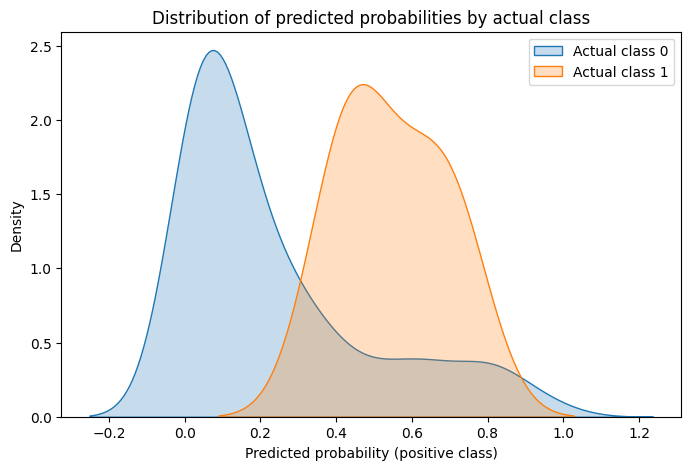

In [13]:
# Combine into one DataFrame for easy plotting
import pandas as pd
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()